In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from time import perf_counter
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [2]:
model = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(model)

In [3]:
# KVv-cache text generation
prompt = "The quick brown fox jumps over the"
inputs = tokenizer(prompt, return_tensors="pt")


def generate_text_with_past(inputs):
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate(inputs, max_tokens):
    
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = generate_text_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)), # passing only the last token i.e the generated token
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])], 
                dim=1
            ),
            "past_key_values": past_key_values
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

 fence and runs into the bushes.

"


In [4]:
# Padding tokens
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [5]:
# Define the padding function
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [6]:
# Tokenize a list of prompts
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [7]:
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])


In [8]:
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


In [9]:
# Add position ids to track the original order of the tokens in each sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)  # replace the padding tokens with 1

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [10]:
# Calculate the logits
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)

logits = outputs.logits
last_logits = logits[:, -1, :]
next_token_id = last_logits.argmax(dim=1)
print("next_token_id:", next_token_id)
next_tokens = tokenizer.batch_decode(next_token_id)
print("next_tokens:", next_tokens)

next_token_id: tensor([13990,   319,   307])
next_tokens: [' fence', ' on', ' be']


In [11]:
inputs["input_ids"].shape

torch.Size([3, 7])

In [12]:
# Generating n tokens for each prompt
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [13]:
generated_tokens = generate_batch(inputs, max_tokens=10)

for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



In [16]:
# Throughput vs Latency

# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = perf_counter()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = perf_counter() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.5419678000034764
throughput 18.451280684822706
avg latency 0.054196780000347645

bs= 2
duration 0.6104360000463203
throughput 32.76346742079823
avg latency 0.06104360000463203

bs= 4
duration 0.6358166000572965
throughput 62.911223136350024
avg latency 0.06358166000572965

bs= 8
duration 0.9152796999551356
throughput 87.40497577289365
avg latency 0.09152796999551356

bs= 16
duration 0.9660803999286145
throughput 165.61768566241764
avg latency 0.09660803999286145

bs= 32
duration 1.0330223999917507
throughput 309.7706303392408
avg latency 0.10330223999917507

bs= 64
duration 1.7001749000046402
throughput 376.43186003878384
avg latency 0.170017490000464

bs= 128
duration 2.7088818000629544
throughput 472.5196942776362
avg latency 0.27088818000629544



In [17]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

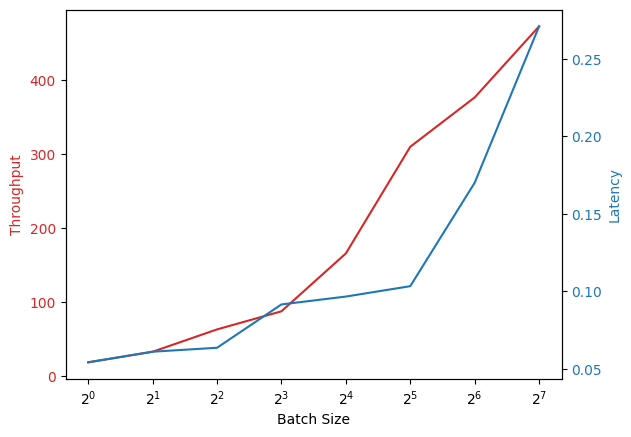

In [18]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)